In [1]:
import pandas as pd
import numpy as np

def load_and_merge_data(base_path='C:/Users/this pc/Documents/cart_project'):
    """
    Loads Instacart datasets with type optimization to save memory.
    Merges them into a single analytical dataframe.
    """
    print("⏳ Loading data...")
    
    # 1. Load Products & Departments (Small files)
    products = pd.read_csv(f'{base_path}/products.csv')
    departments = pd.read_csv(f'{base_path}/departments.csv')
    
    # Map department names to products immediately for clarity
    product_dept = products.merge(departments, on='department_id', how='left')
    
    # 2. Load Orders (Meta data: Who and When)
    # Optimization: Use smaller integers for IDs and categories for strings
    orders = pd.read_csv(
        f'{base_path}/orders.csv',
        dtype={
            'order_id': np.int32,
            'user_id': np.int32,
            'order_number': np.int16,
            'order_dow': np.int8,
            'order_hour_of_day': np.int8,
            'days_since_prior_order': np.float32
        }
    )
    
    # 3. Load Order Products (The actual items: Massive file)
    # We will use 'order_products__prior.csv' for training history
    order_products = pd.read_csv(
        f'{base_path}/order_products__prior.csv',
        dtype={
            'order_id': np.int32,
            'product_id': np.int32,
            'add_to_cart_order': np.int16,
            'reordered': np.int8
        }
    )

    print("🔗 Merging datasets...")
    
    # Merge items with their product details (to get department_id)
    # We use inner join because we only care about items we can identify
    merged_items = order_products.merge(product_dept[['product_id', 'department_id', 'department']], on='product_id', how='inner')
    
    # Merge item details with user/order details
    full_df = merged_items.merge(orders, on='order_id', how='inner')
    
    print(f"✅ Data Loaded. Shape: {full_df.shape}")
    print(f"   Unique Users: {full_df['user_id'].nunique()}")
    
    return full_df
df = load_and_merge_data(base_path='C:/Users/this pc/Documents/cart_project')

⏳ Loading data...
🔗 Merging datasets...
✅ Data Loaded. Shape: (32434489, 12)
   Unique Users: 206209


In [2]:
def create_target_variable(df):
    """
    Creates the 'is_baby_shopper' label.
    Logic: If a user has EVER bought from dept_id 18, they are a Class 1.
    """
    print("🎯 Creating Target Variable...")
    
    # 1. Identify transactions involving baby products (Dept 18)
    # We create a boolean flag per row
    df['is_baby_product'] = (df['department_id'] == 18).astype(int)
    
    # 2. Group by User to see if they ever bought a baby product
    # taking the 'max' of the boolean flag acts as an 'OR' gate. 
    # If they bought it once, max will be 1.
    user_labels = df.groupby('user_id')['is_baby_product'].max().reset_index()
    user_labels.rename(columns={'is_baby_product': 'is_baby_shopper'}, inplace=True)
    
    # Check class balance
    class_dist = user_labels['is_baby_shopper'].value_counts(normalize=True)
    print(f"📊 Class Distribution:\n{class_dist}")
    
    return user_labels

# EXECUTION
target_df = create_target_variable(df)

🎯 Creating Target Variable...
📊 Class Distribution:
is_baby_shopper
0    0.836428
1    0.163572
Name: proportion, dtype: float64


In [3]:
def engineer_features(df):
    """
    Aggregates order-level data into user-level behavioral features.
    """
    print("🛠️ Engineering Features...")
    
    # 1. Define Department Categories (Domain Knowledge)
    # Dept 4: Produce, Dept 16: Dairy/Eggs (Proxies for 'Healthy/Cooking')
    # Dept 19: Snacks, Dept 5: Alcohol (Proxies for 'Junk/Vice')
    healthy_depts = [4, 16] 
    junk_depts = [19, 5]
    
    # Create flags for healthy vs junk items
    df['is_healthy'] = df['department_id'].isin(healthy_depts).astype(int)
    df['is_junk'] = df['department_id'].isin(junk_depts).astype(int)
    
    # 2. Aggregation: Compress millions of rows into one row per user
    user_features = df.groupby('user_id').agg({
        'order_id': 'nunique',              # Total Orders
        'days_since_prior_order': 'mean',   # Frequency (Volume Drift)
        'order_hour_of_day': 'mean',        # Time of day (Insomnia Index)
        'is_healthy': 'mean',               # % of basket that is healthy
        'is_junk': 'mean',                  # % of basket that is junk
        'reordered': 'mean'                 # Loyalty/Stickiness
    }).reset_index()
    
    # Rename columns for clarity
    user_features.rename(columns={
        'order_id': 'total_orders',
        'days_since_prior_order': 'avg_days_between_orders',
        'order_hour_of_day': 'avg_order_hour',
        'is_healthy': 'healthy_ratio',
        'is_junk': 'junk_ratio',
        'reordered': 'reorder_rate'
    }, inplace=True)
    
    # 3. Ratio Feature: The "Health-Conscious" Score
    # Avoid division by zero by adding a small epsilon if needed, but here simple subtraction works too
    # High positive = Very Healthy; Negative = Junk focused
    user_features['health_junk_diff'] = user_features['healthy_ratio'] - user_features['junk_ratio']
    
    print(f"✅ Features Engineered. Shape: {user_features.shape}")
    return user_features

# EXECUTION
# 1. Create the features
feature_df = engineer_features(df)

# 2. Merge with the Target Variable (from Phase 1)
# This creates our final "Analytical Base Table" (ABT)
final_abt = feature_df.merge(target_df, on='user_id', how='left')

# 3. Sanity Check
print(final_abt.head())

🛠️ Engineering Features...
✅ Features Engineered. Shape: (206209, 8)
   user_id  total_orders  avg_days_between_orders  avg_order_hour  \
0        1            10                20.259260       10.542373   
1        2            14                15.967033       10.441026   
2        3            12                11.487180       16.352273   
3        4             5                15.357142       13.111111   
4        5             4                14.500000       15.729730   

   healthy_ratio  junk_ratio  reorder_rate  health_junk_diff  is_baby_shopper  
0       0.305085    0.372881      0.694915         -0.067797                0  
1       0.430769    0.215385      0.476923          0.215385                0  
2       0.670455    0.102273      0.625000          0.568182                0  
3       0.111111    0.166667      0.055556         -0.055556                0  
4       0.729730    0.027027      0.378378          0.702703                0  


In [4]:
final_abt.corr()['is_baby_shopper']

user_id                   -0.000165
total_orders               0.219902
avg_days_between_orders   -0.148012
avg_order_hour            -0.001430
healthy_ratio             -0.012602
junk_ratio                -0.060267
reorder_rate               0.122042
health_junk_diff           0.016355
is_baby_shopper            1.000000
Name: is_baby_shopper, dtype: float64

In [5]:
!pip install xgboost

In [6]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_propensity_model(abt):
    """
    Trains an XGBoost classifier to predict 'is_baby_shopper'.
    """
    print("🤖 Initializing Model Training...")

    # 1. Prepare X (Features) and y (Target)
    # Drop non-feature columns (user_id) and the target itself
    X = abt.drop(['user_id', 'is_baby_shopper'], axis=1)
    y = abt['is_baby_shopper']

    # 2. Split Data (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Initialize XGBoost
    # scale_pos_weight is crucial! It tells the model:
    # "Pay more attention to the minority class (parents)."
    # Roughly calculated as: (Number of Negatives) / (Number of Positives)
    # Since we saw ~16% positives, a weight of ~5 is a good starting point.
    model = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=5, 
        eval_metric='logloss',
        use_label_encoder=False
    )

    # 4. Train
    model.fit(X_train, y_train)
    
    # 5. Predict
    y_pred = model.predict(X_test)
    
    # 6. Evaluation
    print("\n--- Model Performance Report ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return model, X.columns

# EXECUTION
# final_abt is from the previous step
model, feature_names = train_propensity_model(final_abt)

🤖 Initializing Model Training...


C:\Users\this pc\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:52:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Performance Report ---
Accuracy: 0.6585

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76     34374
           1       0.28      0.65      0.39      6868

    accuracy                           0.66     41242
   macro avg       0.59      0.66      0.58     41242
weighted avg       0.80      0.66      0.70     41242



In [7]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


🤖 Initializing XGBoost Training...


C:\Users\this pc\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:56:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Performance Report ---
Accuracy: 0.6585

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76     34374
           1       0.28      0.65      0.39      6868

    accuracy                           0.66     41242
   macro avg       0.59      0.66      0.58     41242
weighted avg       0.80      0.66      0.70     41242



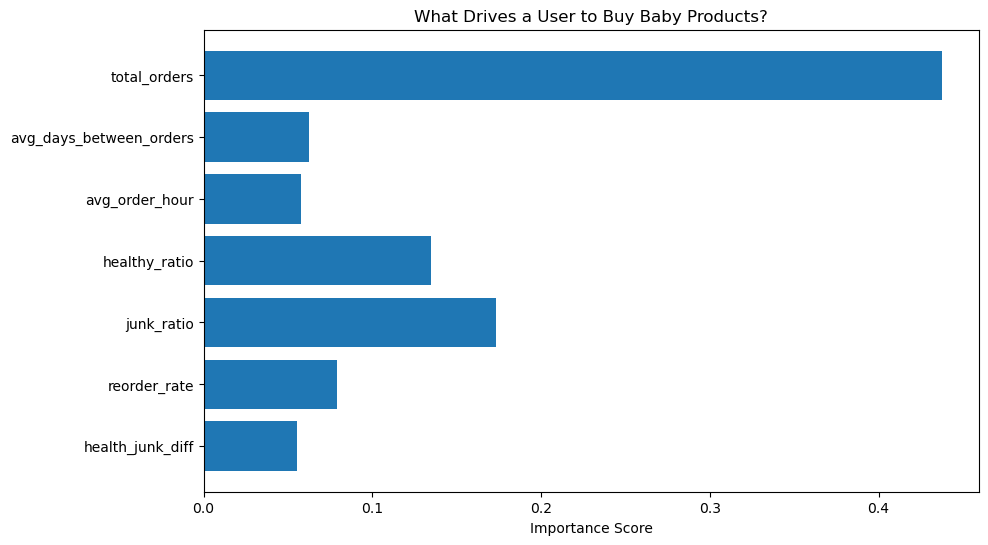

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Aggressive Model Training
def train_aggressive_model(abt):
    print("😈 Training Aggressive Model...")

    # 1. Prepare X and y
    X = abt.drop(['user_id', 'is_baby_shopper'], axis=1)
    y = abt['is_baby_shopper']

    # 2. Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Initialize XGBoost with AGGRESSIVE hyperparams
    # scale_pos_weight=10: Tells model "It is 10x worse to miss a parent than to be wrong about a non-parent"
    model = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=10,  # DOUBLED (Was 5)
        max_depth=5,          # INCREASED (Allows more complex logic)
        learning_rate=0.1,
        eval_metric='logloss',
        use_label_encoder=False
    )

    # 4. Train
    model.fit(X_train, y_train)
    
    # 5. Save immediately
    joblib.dump(model, 'cartsignal_model.pkl')
    print("✅ Aggressive Model Saved as 'cartsignal_model.pkl'")
    return model

# EXECUTION
    aggressive_model = train_aggressive_model(final_abt)
    
    # 6. Evaluation
    print("\n--- Model Performance Report ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # 7. Plot Feature Importance
    importance = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(X.columns, importance)
    plt.title('What Drives a User to Buy Baby Products?')
    plt.xlabel('Importance Score')
    plt.gca().invert_yaxis() 
    plt.show()
    
    return model

# EXECUTION
model = train_propensity_model(final_abt)

In [17]:
import joblib

# Save the model to a file
joblib.dump(model, 'cartsignal_model.pkl')
print("✅ Model saved as 'cartsignal_model.pkl'")

✅ Model saved as 'cartsignal_model.pkl'
